In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import yfinance as yf
from sklearn.linear_model import LinearRegression
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from numpy import array

In [ ]:
def get_ticker(name):
    company = yf.Ticker(name)
    return company

In [ ]:
stock2 = get_ticker("ANTM.JK")

df = stock2.history(period="5y")

In [ ]:
df = df.reset_index(level=0)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-06-19 00:00:00+07:00,866.260437,866.260437,866.260437,866.260437,0,0.0,0.0
1,2018-06-20 00:00:00+07:00,851.902566,856.688536,818.400780,842.330627,64935900,0.0,0.0
2,2018-06-21 00:00:00+07:00,842.330649,866.260497,837.544679,851.902588,52368400,0.0,0.0
3,2018-06-22 00:00:00+07:00,861.474509,871.046448,842.330631,871.046448,42965100,0.0,0.0
4,2018-06-25 00:00:00+07:00,885.404375,885.404375,842.330649,851.902588,91154400,0.0,0.0


In [ ]:
df=df[:-1]

In [ ]:
df1=df.reset_index()['Close']

In [ ]:
df1

0        866.260437
1        842.330627
2        851.902588
3        871.046448
4        851.902588
           ...     
1234    1995.000000
1235    2010.000000
1236    2030.000000
1237    2040.000000
1238    2060.000000
Name: Close, Length: 1239, dtype: float64

In [ ]:
dataset = df.filter(['Close']).values

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df2

array([[0.18986363],
       [0.18125377],
       [0.18469773],
       ...,
       [0.60857318],
       [0.61217114],
       [0.61936708]])

#### Training

In [ ]:
trainingDataLen = math.ceil(len(df2) * 0.80)
print('Size of trainingSet: ' + str(trainingDataLen))

Size of trainingSet: 992


In [ ]:
trainData = df2[:trainingDataLen , :]

In [ ]:
# Split into trained x and y
xTrain = []
yTrain = []
for i in range(60, len(trainData)):
    xTrain.append(trainData[i-60:i , 0])
    yTrain.append(trainData[i , 0])

# Convert trained x and y as numpy array
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
print('x - y train shape: ' + str(xTrain.shape) + ' ' + str(yTrain.shape))

# Reshape x trained data as 3 dimension array
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
print('Expected x train shape: ' + str(xTrain.shape))

x - y train shape: (932, 60) (932,)
Expected x train shape: (932, 60, 1)


In [ ]:
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
print('x - y train shape: ' + str(xTrain.shape) + ' ' + str(yTrain.shape))

x - y train shape: (932, 60, 1) (932,)


In [ ]:
estop=tf.keras.callbacks.EarlyStopping(monitor="loss", patience=125, verbose=1,
                                        restore_best_weights=True)

#### Learning Rate 0.001


In [ ]:
model = Sequential()
model.add(LSTM(450, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
model.add(LSTM(250, return_sequences=True))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
model.fit(xTrain, yTrain, batch_size=10, epochs=10000, callbacks=[estop])

Epoch 1/10000
94/94 [==============================] - 18s 24ms/step - loss: 0.0720
Epoch 2/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0425
Epoch 3/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0349
Epoch 4/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0333
Epoch 5/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0340
Epoch 6/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0270
Epoch 7/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0287
Epoch 8/10000
94/94 [==============================] - 2s 22ms/step - loss: 0.0295
Epoch 9/10000
94/94 [==============================] - 2s 19ms/step - loss: 0.0237
Epoch 10/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0206
Epoch 11/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0227
Epoch 12/10000
94/94 [==============================] - 2s 17ms/step - loss: 0.0245


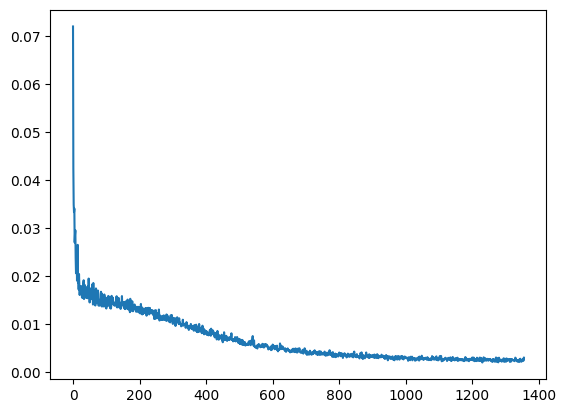

In [ ]:
loss = model.history.history['loss']
plt.plot(loss)

In [ ]:
testData = df2[trainingDataLen - 60: , :]

In [ ]:
xTest = []
yTest = dataset[trainingDataLen: , :]
for i in range(60, len(testData)):
    xTest.append(testData[i - 60:i, 0])

In [ ]:
xTest = np.array(xTest)

In [ ]:
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

In [ ]:
predictions = model.predict(xTest)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 2s 13ms/step


In [ ]:
mape = np.mean(np.abs((yTest - predictions) / yTest)) * 100
print('\nMAPE:' + str(mape))


MAPE:7.8033908183345115


#### Visualisasi

In [ ]:
print(predictions)

[[2187.526 ]
 [2160.958 ]
 [2192.5935]
 [2224.0615]
 [2099.3704]
 [2185.1328]
 [2088.0493]
 [2037.7203]
 [2032.4324]
 [1930.7295]
 [1900.6509]
 [1827.2609]
 [1897.3737]
 [1874.1222]
 [1806.8811]
 [1835.2379]
 [1827.5278]
 [1772.5159]
 [1817.2368]
 [1779.3757]
 [1719.3684]
 [1666.3479]
 [1753.9762]
 [1708.662 ]
 [1691.066 ]
 [1711.8221]
 [1819.8002]
 [1938.2626]
 [1901.6654]
 [1841.366 ]
 [1977.9747]
 [2059.593 ]
 [2138.8274]
 [1916.4097]
 [1976.4812]
 [2106.566 ]
 [2093.5554]
 [2210.085 ]
 [2233.9604]
 [2217.0686]
 [2390.0896]
 [2313.8958]
 [2363.855 ]
 [2382.884 ]
 [2296.6106]
 [2375.579 ]
 [2246.2297]
 [2319.1436]
 [2279.4568]
 [2278.5115]
 [2254.6594]
 [2227.515 ]
 [2265.38  ]
 [2237.493 ]
 [2257.6135]
 [2184.2256]
 [2200.47  ]
 [2195.413 ]
 [2151.201 ]
 [2088.6067]
 [2074.912 ]
 [2126.4128]
 [2125.076 ]
 [2198.9543]
 [2176.7693]
 [2189.959 ]
 [2190.6338]
 [2195.101 ]
 [2240.8303]
 [2245.1775]
 [2223.8857]
 [2224.592 ]
 [2209.3975]
 [2187.681 ]
 [2201.932 ]
 [2247.6003]
 [2231.9016]

In [ ]:
train = df.loc[:trainingDataLen, ['Date', 'Close'] ]
valid = df.loc[trainingDataLen:, ['Date', 'Close'] ]
print('validLength: {}, predictionLength: {}'.format(len(valid), len(predictions)))

validLength: 247, predictionLength: 247


In [ ]:
dfPrediction = pd.DataFrame(predictions, columns = ['predictions'])

In [ ]:
valid = valid.reset_index()
dfPrediction = dfPrediction.reset_index()

In [ ]:
valid = pd.concat([valid, dfPrediction], axis=1)

In [ ]:
print(valid)

     index                      Date   Close  index  predictions
0      992 2022-06-17 00:00:00+07:00  2110.0      0  2187.525879
1      993 2022-06-20 00:00:00+07:00  2070.0      1  2160.958008
2      994 2022-06-21 00:00:00+07:00  2150.0      2  2192.593506
3      995 2022-06-22 00:00:00+07:00  2020.0      3  2224.061523
4      996 2022-06-23 00:00:00+07:00  1965.0      4  2099.370361
..     ...                       ...     ...    ...          ...
242   1234 2023-06-12 00:00:00+07:00  1995.0    242  2131.066162
243   1235 2023-06-13 00:00:00+07:00  2010.0    243  2139.138672
244   1236 2023-06-14 00:00:00+07:00  2030.0    244  2136.568115
245   1237 2023-06-15 00:00:00+07:00  2040.0    245  2139.120361
246   1238 2023-06-16 00:00:00+07:00  2060.0    246  2165.743896

[247 rows x 5 columns]


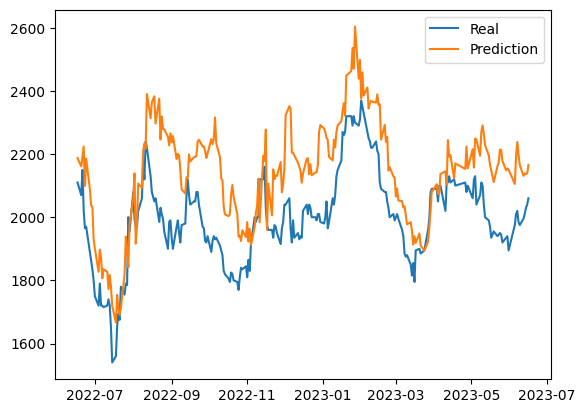

In [ ]:
plt.plot(valid['Date'], valid[['Close', 'predictions']])
plt.legend(['Real','Prediction'])

#### Predictions


In [ ]:
for i in range(30):
  x_for_pred = df2[-60:].reshape(1, 60, 1)
  prediction = model.predict(x_for_pred)
  df2 = np.append(df2, prediction)

In [ ]:
predictFor30D = df2[-30:]

In [ ]:
predictFor30D = predictFor30D.reshape(-1, 1)
predictFor30D = scaler.inverse_transform(predictFor30D)
predictFor30D

array([[2020.77201879],
       [2081.57794417],
       [2167.96772311],
       [2207.08997665],
       [2246.94395949],
       [2324.59937232],
       [2428.60399739],
       [2488.94739431],
       [2544.21904747],
       [2592.75852611],
       [2630.87802724],
       [2585.81596077],
       [2506.31987687],
       [2506.49332504],
       [2473.64386514],
       [2401.06069307],
       [2410.53540289],
       [2397.52861243],
       [2376.00182256],
       [2373.2556427 ],
       [2382.00839729],
       [2376.44811613],
       [2381.12376192],
       [2382.06389408],
       [2384.31739499],
       [2387.43465785],
       [2383.45611797],
       [2356.66177179],
       [2347.32936568],
       [2343.56370154]])

In [ ]:
import datetime

def date_weekday(from_date, add_days):
    weekday_to_add = add_days
    current_date = from_date
    while weekday_to_add > 0:
        current_date += datetime.timedelta(days=1)
        weekday = current_date.weekday()
        if weekday >= 5:
            continue
        weekday_to_add -= 1
    return current_date

datenow = datetime.date.today()
datePred = []

for x in range (30):
    hariKerja = date_weekday(datenow,1)
    datenow = hariKerja
    datePred.append(hariKerja)

In [ ]:
predictFor30D = pd.DataFrame(predictFor30D, columns = ['Prediction'])

In [ ]:
datePred = pd.DataFrame(datePred, columns = ['Date'])

In [ ]:
datePred = datePred.reset_index()
predictFor30D = predictFor30D.reset_index()

In [ ]:
finalPred = pd.concat([datePred, predictFor30D], axis=1)

In [ ]:
finalPred = finalPred.drop(columns=['index'])

In [ ]:
finalPred

,Date,Prediction
0,2023-05-22,2020.772019
1,2023-05-23,2081.577944
2,2023-05-24,2167.967723
3,2023-05-25,2207.089977
4,2023-05-26,2246.943959
5,2023-05-29,2324.599372
6,2023-05-30,2428.603997
7,2023-05-31,2488.947394
8,2023-06-01,2544.219047
9,2023-06-02,2592.758526


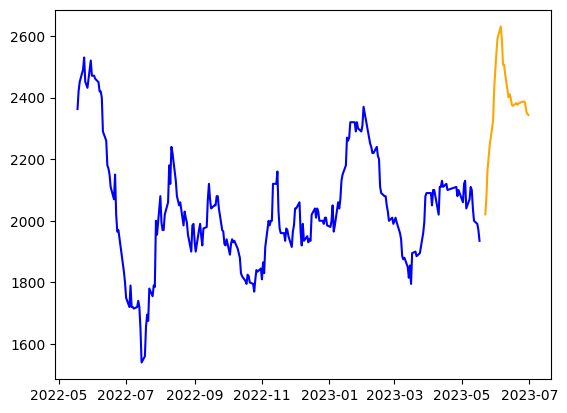

In [ ]:
plt.plot(valid['Date'], valid['Close'], 'b', finalPred['Date'], finalPred['Prediction'], 'orange')
plt.show()

In [ ]:
model.save('ANTM.h5')